In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, r2_score
from icecream import ic
from utils import *    
import time

plt.style.use('seaborn')
np.__version__

/tmp/ipykernel_220706/1081107391.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'1.24.4'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/WineQT.csv').drop(columns=['Id'], axis=0)

scaler = StandardScaler()

df['quality'] = df['quality'].map(lambda x : 0 if x <= 5 else 1)

df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

df_train, df_val = train_test_split(df, test_size=0.2)

X_train_c, y_train_c = df_train.values[:, :-1], pd.get_dummies(df_train.values[:, -1], dtype=np.float32).values
X_val_c, y_val_c = df_val.values[:, :-1], pd.get_dummies(df_val.values[:, -1], dtype=np.float32).values

X_train_c.shape, X_val_c.shape, y_train_c.shape, y_val_c.shape


((914, 11), (229, 11), (914, 2), (229, 2))

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/HousingData.csv')
nan_cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'AGE', 'LSTAT']
for col in nan_cols:
    df[col] = df[col].fillna(df[col].mean(), inplace=False)
    

scaler = StandardScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
# df_scaled = pd.DataFrame(df, columns=df.columns)


X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(df.iloc[:, :-1].values, df.iloc[:, -1].values, test_size=0.1)
y_train_r, y_val_r = y_train_r.reshape(-1, 1), y_val_r.reshape(-1, 1)

X_train_r.shape, y_train_r.shape, X_val_r.shape, y_val_r.shape


((455, 13), (455, 1), (51, 13), (51, 1))

## Random Forest

In [4]:
rf_regression = Bagging(
    X=X_train_r,
    y=y_train_r.reshape(-1, 1), 
    bootstrap=False,
    frac=0.25,
    model_list=[DecisionTree(criterion='squared_error', max_depth=3, task='regression')],
    num_estimators=10,
    task='regression',
    voting_mechanism='hard'
)

rf_regression.train()

r2_score(rf_regression(X_val_r), y_val_r)

Accuracy of decision tree: 0.833632117830295
Accuracy of decision tree: 0.8330443118685218
Accuracy of decision tree: 0.724306155753037
Accuracy of decision tree: 0.8498775235757605
Accuracy of decision tree: 0.8521234305290369
Accuracy of decision tree: 0.8445356228274229
Accuracy of decision tree: 0.9245542184553939
Accuracy of decision tree: 0.8231783450721802
Accuracy of decision tree: 0.8895205973394009
Accuracy of decision tree: 0.8275525492149098
Training done!


0.7048071645572723

In [169]:

def indentity(x, axis):
    return x

def find_best_model(X_train, y_train, X_val, y_val, task, transform_y, accuracy_fxn, base_model):
    
    df = {
        'num_estimator' : [],
        'frac': [],
        'voting': [],
        'train_acc': [], 'val_acc': []
    }
    
    for num_estimator in tqdm(range(1, 30, 3)):
        for frac in [0.15, 0.25, 0.50, 0.75, 1.0]:
            for voting in ['hard', 'soft']:
                for bootstrap in [True, False]:
                    bag = Bagging(
                        model_list=[base_model],
                        X=X_train,
                        y=y_train,
                        frac=frac,
                        num_estimators=num_estimator,
                        bootstrap=bootstrap,
                        voting_mechanism=voting,
                        task=task
                    )
                    
                    bag.train()
                    
                    df['train_acc'].append(accuracy_fxn(transform_y(y_train, -1), bag(X_train)))
                    df['val_acc'].append(accuracy_fxn(transform_y(y_val, -1), bag(X_val)))
                    df['num_estimator'].append(num_estimator)
                    df['frac'].append(frac)
                    df['voting'].append(voting)
                    
    df = pd.DataFrame(df).sort_values(by='val_acc', ascending=False)
    df.to_csv(f'random_forest_all_combinations_{task}.csv', index=False)
    return df
    
    
# df_regression = find_best_model(X_train_r, 
#                                 y_train_r.reshape(-1, 1), 
#                                 X_val_r, 
#                                 y_val_r.reshape(-1,1), 
#                                 task='regression', 
#                                 transform_y=indentity, 
#                                 accuracy_fxn=r2_score,
#                                 base_model=DecisionTree(criterion='squared_error', max_depth=2, task='regression'))

df_regression = pd.read_csv('./random_forest_all_combinations_regression.csv')
df_regression

,num_estimator,frac,voting,train_acc,val_acc
0,4,0.25,hard,0.723711,0.728925
1,7,0.25,hard,0.744514,0.724266
2,13,0.15,hard,0.768153,0.714237
3,19,0.15,soft,0.791170,0.698415
4,10,0.25,hard,0.755705,0.697989
...,...,...,...,...,...
195,1,0.75,hard,0.689491,0.437600
196,1,0.25,soft,0.621100,0.395497
197,1,0.15,hard,0.681080,0.387785
198,4,0.15,hard,0.681236,0.377733


In [170]:
# df_classification = find_best_model(X_train_c, 
#                                 y_train_c, 
#                                 X_val_c, 
#                                 y_val_c, 
#                                 task='classification', 
#                                 transform_y=np.argmax, 
#                                 accuracy_fxn=accuracy_score,
#                                 base_model=DecisionTree(criterion='entropy', max_depth=2, task='classification'))

df_classification = pd.read_csv('./random_forest_all_combinations_classification.csv')
df_classification

,num_estimator,frac,voting,train_acc,val_acc
0,25,0.15,hard,0.759300,0.759825
1,10,0.25,soft,0.756018,0.755459
2,4,0.15,soft,0.745077,0.751092
3,13,0.15,hard,0.750547,0.751092
4,10,0.15,hard,0.759300,0.746725
...,...,...,...,...,...
195,7,0.75,hard,0.715536,0.637555
196,1,0.50,soft,0.712254,0.615721
197,1,0.75,hard,0.704595,0.602620
198,4,1.00,hard,0.702407,0.598253


## AdaBoost

In [10]:
class AdaBoostClassifier:
    def __init__(self,
                 n_estimators:  int,
                 X:             np.ndarray,
                 y:             np.ndarray,):
    
        self.n_estimators = n_estimators
        self.stumps = []
        self.X = X
        self.y = y
        self.data_weights = np.ones(len(self.X)) / len(self.X)
        self.model_weights = []
        self.features_to_take = []
        self.lr = 1e-2
        
    def get_best_stump(self, X, y):
        model = DecisionTreeClassifier(max_depth=1).fit(X, y)
        return model
    
    def calculate_alpha(self, error):
        error = error + 1e-6
        return 0.5 * np.log((1-error)/error)
        
    def get_bin_index(self, arr, n):
        idx = n > arr
        return np.where(idx == False)[0][0]    
    
    def update_dataset(self, y_true, y_pred):
        misclassified = (y_true != y_pred).astype(np.float32)
        error = np.sum(misclassified * self.data_weights)
        alpha = self.lr * self.calculate_alpha(error)
        
        # ic(error, alpha)
        
        self.data_weights = self.data_weights * (np.exp(alpha * misclassified)  + (1 - misclassified) * np.exp(-alpha))
        self.data_weights = self.data_weights/np.sum(self.data_weights)
        
        new_X, new_y = [], []
        
        for i in range(len(self.X)):
            t = np.random.uniform(0, 1)
            idx = self.get_bin_index(np.cumsum(self.data_weights), t)
            new_X.append(self.X[idx])
            new_y.append(self.y[idx])
            
        return np.array(new_X), np.array(new_y), alpha
        
    def train(self):  
        self.time_taken = time.time()
        
        for _ in tqdm(range(self.n_estimators)):      
            self.stumps.append(self.get_best_stump(self.X, self.y))
            pred = self.stumps[-1].predict(self.X)
            self.X, self.y, model_weight = self.update_dataset(np.argmax(self.y, -1), np.argmax(pred, -1))
            self.model_weights.append(model_weight)
            
        self.model_weights = self.model_weights/np.sum(self.model_weights)
        self.time_taken = time.time() - self.time_taken
            
    def predict(self, X):
        pred = []
    
        for model in self.stumps:
            pred.append(model.predict(X))
                
        pred = np.array(pred) * (np.array(self.model_weights)[:, None, None])
        # ic(pred.shape)
        pred = np.sum(pred, axis=0)
        # ic(pred.shape)
        return np.argmax(pred, axis=1)    


In [11]:
class AdaBoostRegressor:
    def __init__(self,
                 n_estimators:  int,
                 X:             np.ndarray,
                 y:             np.ndarray):
    
        self.n_estimators = n_estimators
        self.stumps = []
        self.X = X
        self.y = y
        self.data_weights = np.ones(len(self.X)) / len(self.X)
        self.model_weights = []
        self.features_to_take = []
        self.lr = 0.01
        
    def get_best_stump(self, X, y):
        model = DecisionTreeRegressor(max_depth=3).fit(X, y)
        return model
    
    def calculate_alpha(self, error):
        error = error + 1e-6
        return 0.5 * np.log((1-error)/error)
        
    def get_bin_index(self, arr, n):
        idx = n > arr
        return np.where(idx == False)[0][0]    
    
    def update_dataset(self, y_true, y_pred):
        misclassified = np.abs(y_true.ravel() - y_pred)
        misclassified = (misclassified > 2*np.mean(misclassified)).astype(np.float32)
        # ic(np.sum(misclassified))
        error = np.sum(misclassified * self.data_weights)
        alpha = self.lr * self.calculate_alpha(error)
    
        self.data_weights = self.data_weights * (np.exp(alpha * misclassified)  + (1 - misclassified) * np.exp(-alpha))
        self.data_weights = self.data_weights/np.sum(self.data_weights)
        
        new_X, new_y = [], []
        
        for i in range(len(self.X)):
            t = np.random.uniform(0, 1)
            idx = self.get_bin_index(np.cumsum(self.data_weights), t)
            new_X.append(self.X[idx])
            new_y.append(self.y[idx])
            
        return np.array(new_X), np.array(new_y), alpha
        
    def train(self):
        self.time_taken = time.time()  
        for _ in tqdm(range(self.n_estimators)):      
            self.stumps.append(self.get_best_stump(self.X, self.y))
            pred = self.stumps[-1].predict(self.X)
            self.X, self.y, model_weight = self.update_dataset(self.y, pred)
            self.model_weights.append(model_weight)
            
        self.model_weights = self.model_weights/np.sum(self.model_weights)
        self.time_taken = time.time() - self.time_taken
            
    def predict(self, X):
        pred = []
        for model in self.stumps:
            pred.append(model.predict(X))
    
        pred = np.array(pred) * (np.array(self.model_weights)[:, None])
        pred = np.sum(pred, axis=0)
        return pred


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

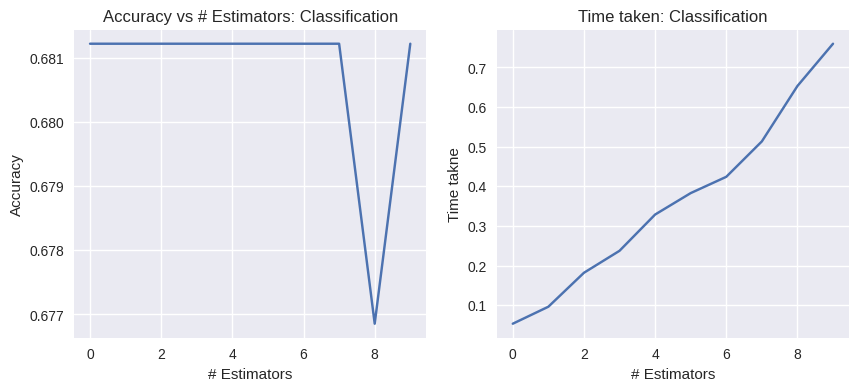

In [14]:
scores, time_taken = [], []

for i in range(1, 50, 5):
    ada = AdaBoostClassifier(
        n_estimators=i,
        X = X_train_c,
        y = y_train_c
    )
    ada.train()
    pred = ada.predict(X_val_c)
    scores.append(accuracy_score(np.argmax(y_val_c, -1), pred))
    time_taken.append(ada.time_taken)

plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.title('Accuracy vs # Estimators: Classification')
plt.xlabel('# Estimators')
plt.ylabel('Accuracy')
plt.plot(scores)

plt.subplot(1,2,2)
plt.title('Time taken: Classification')
plt.xlabel('# Estimators')
plt.ylabel('Time takne')
plt.plot(time_taken)



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

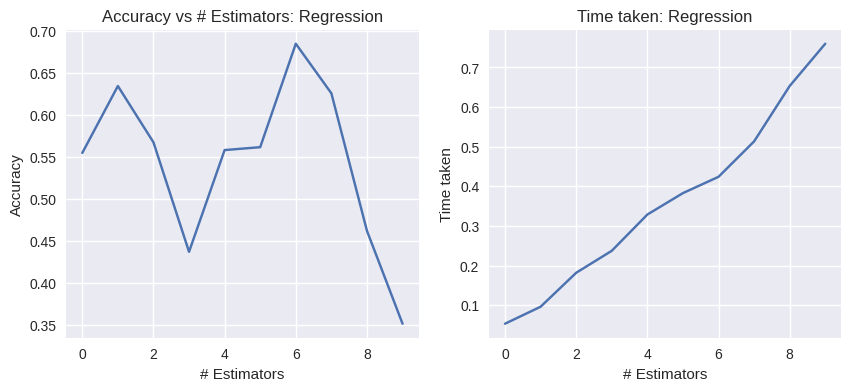

In [15]:

scores = []
for i in range(1, 50, 5):
    ada = AdaBoostRegressor(
        n_estimators=i,
        X = X_train_r,
        y = y_train_r
    )
    ada.train()
    pred = ada.predict(X_val_r)
    scores.append(r2_score(y_val_r, pred))
    
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.title('Accuracy vs # Estimators: Regression')
plt.xlabel('# Estimators')
plt.ylabel('Accuracy')
plt.plot(scores)

plt.subplot(1,2,2)
plt.title('Time taken: Regression')
plt.xlabel('# Estimators')
plt.ylabel('Time taken')
plt.plot(time_taken)
        

## Gradient Boosting

In [11]:
class GradientBoostingRegressor:
    def __init__(self,
                 n_estimators:  int,
                 X:             np.ndarray,
                 y:             np.ndarray,
                 verbose=True       ):
        
        self.n_estimators = n_estimators
        self.X = X
        self.y = y
        self.lr = 5e-2
        self.estimators = []
        self.verbose = verbose
    
    def train(self):
        self.time_taken = time.time()
        self.residuals = []
        for i in range(self.n_estimators):
            if i == 0:
                self.residuals = self.y - np.mean(self.y)        
            else:
                dt = DecisionTreeRegressor(max_depth=3).fit(self.X, self.residuals)
                self.residuals = self.residuals - self.lr * dt.predict(self.X)
                self.estimators.append(dt)
            
            if self.verbose:    
                ic(np.mean(self.residuals))
                            
        self.time_taken = time.time() - self.time_taken
        
    def predict(self, X):
        pred = None
        for i in range(self.n_estimators):
            if i == 0:
                pred = np.mean(self.y)
            else:
                pred += self.lr * self.estimators[i-1].predict(X)
                
        return pred
    
    
class GradientBoostClassifier:
    def __init__(self,
                 n_estimators:  int,
                 X:             np.ndarray,
                 y:             np.ndarray,
                 verbose=True       ):
        
        self.n_estimators = n_estimators
        self.verbose = verbose
        self.X = X
        self.y = y
        self.estimators = []
        self.residuals = [] 
        self.lr = 1
        self.probabilities = []
        self.n_samples = len(y)
        self.y = np.argmax(self.y, axis=-1)
        
    def log_odds_2_prob(self, log_odds):
        return 1/(1 + np.exp(-1 * log_odds))
        
    def get_node_indices(self, model, x):
        return model.apply(x)
    
    def train(self):
        self.time_taken = time.time()
        
        log_odds = np.log(np.sum(np.array(self.y) == 1)/np.sum(np.array(self.y) == 0))
        log_odds_array = [log_odds] * self.n_samples

        for i in range(self.n_estimators):
            if i == 0:
                pred_probab = self.log_odds_2_prob(log_odds)
                probabs = [pred_probab] * self.n_samples
                self.residuals = self.y - probabs
                self.probabilities = probabs
            else:
                dt = DecisionTreeRegressor(criterion='squared_error', max_depth=3)
                dt.fit(self.X, self.lr * self.residuals)
                self.estimators.append(dt)
                
                leaf_node_indices = self.get_node_indices(dt, self.X)
                new_log_odds = [0] * len(self.y)
                
                for num in np.unique(leaf_node_indices):
                    idx = np.where(np.array(leaf_node_indices) == num)[0]
                    alpha = np.sum(np.array(self.lr * self.residuals)[idx]) / np.sum(np.array(self.probabilities)[idx] * (1 - np.array(self.probabilities)[idx]))
                    new_log_odds = [alpha if i in idx else val for i, val in enumerate(new_log_odds)]
                
                log_odds_array += np.array(new_log_odds)
                probabs_new = self.log_odds_2_prob(log_odds_array)
                self.residuals = self.y - probabs_new
                
                if self.verbose:
                    ic(np.mean(self.residuals))

        self.time_taken = time.time() - self.time_taken
            
    def predict(self, X_test):
        pred = []
        for model in self.estimators:
            pred.append(model.predict(X_test))
        
        pred = np.array(pred)
        pred = np.sum(pred, axis=0)
        pred = 1/(1 + np.exp(-1 * pred))
        pred = np.where(pred > 0.5, 1, 0)
        return pred

In [160]:
gbc = GradientBoostClassifier(
    X=X_train_c,
    y=y_train_c,
    n_estimators=16,
    verbose=False
)
gbc.train()

In [161]:
pred = gbc.predict(X_val_c)
accuracy_score(np.argmax(y_val_c, -1), pred)

0.7161572052401747

In [162]:
gbr = GradientBoostingRegressor(
    X=X_train_r,
    y=y_train_r.ravel(),
    n_estimators=32,
    verbose=False
)


gbr

In [163]:
gbr.train()

In [164]:
r2_score(y_val_r, gbr.predict(X_val_r))

0.7374453063523696

  0%|          | 0/25 [00:00<?, ?it/s]

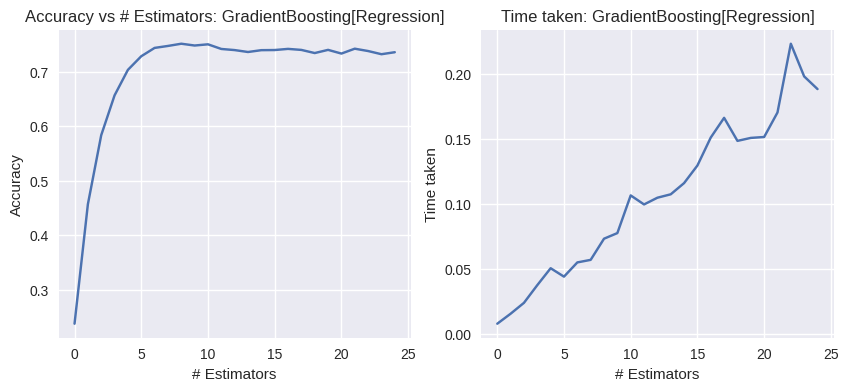

In [165]:
scores, time_taken = [], []

for i in tqdm(range(5, 128, 5)):
    gbr = GradientBoostingRegressor(
        X=X_train_r,
        y=y_train_r.ravel(),
        n_estimators=i,
        verbose=False
    )
    gbr.train()
    pred = gbr.predict(X_val_r)
    scores.append(r2_score(y_val_r, pred))
    time_taken.append(gbr.time_taken)
    
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.title('Accuracy vs # Estimators: GradientBoosting[Regression]')
plt.xlabel('# Estimators')
plt.ylabel('Accuracy')
plt.plot(scores)

plt.subplot(1,2,2)
plt.title('Time taken: GradientBoosting[Regression]')
plt.xlabel('# Estimators')
plt.ylabel('Time taken')
plt.plot(time_taken)

  0%|          | 0/19 [00:00<?, ?it/s]

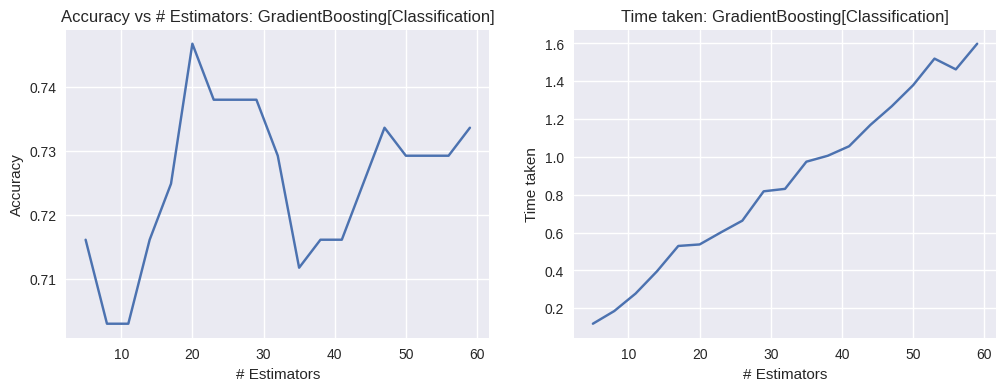

In [171]:
scores, time_taken = [], []

for i in tqdm(range(5, 60, 3)):
    gbr = GradientBoostClassifier(
        X=X_train_c,
        y=y_train_c,
        n_estimators=i,
        verbose=False
    )
    gbr.train()
    pred = gbr.predict(X_val_c)
    scores.append(accuracy_score(np.argmax(y_val_c, -1), pred))
    time_taken.append(gbr.time_taken)
    
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.title('Accuracy vs # Estimators: GradientBoosting[Classification]')
plt.xlabel('# Estimators')
plt.ylabel('Accuracy')
plt.plot(np.arange(5, 60, 3), scores)

plt.subplot(1,2,2)
plt.title('Time taken: GradientBoosting[Classification]')
plt.xlabel('# Estimators')
plt.ylabel('Time taken')
plt.plot(np.arange(5, 60, 3), time_taken)



### Analysis

From the above graphs we can observe that:
1. GradientBoosting performs better than AdaBoost in both regression and the classification task. 

2. GradientBoosting is faster than AdaBoost in regression but slower for classification tasks.

3. Finally, the best performing Random Forest: <br>
    Regression: ```{num_estimators: 4. frac: 0.25, voting: hard, train_acc: 0.723711, val_acc: 0.728925} ``` <br>
    Classification: ```{num_estimators: 25, frac: 0.15, voting: hard, train_acc: 0.759300, val_acc: 0.759825}``` <br>
    performs comparable or little worse to that of Adaboost or GradientBoosting,

4. One reason for comparable results in classification task is because of the dataset itself. Because of intentionally combining some of the labels into one, the accuracy of any model in it is saturated (about 70%).



In [14]:
rf_regression = Bagging(
    X=X_train_c,
    y=y_train_c, 
    bootstrap=False,
    frac=0.15,
    model_list=[DecisionTree(criterion='entropy', max_depth=3, task='classification')],
    num_estimators=25,
    task='classification',
    voting_mechanism='hard'
)

rf_regression.train()


ada = AdaBoostClassifier(
        n_estimators=10,
        X = X_train_c,
        y = y_train_c
    )
ada.train()
    
gbc = GradientBoostClassifier(
    X=X_train_c,
    y=y_train_c,
    n_estimators=16,
    verbose=False
)
gbc.train()

Accuracy of decision tree: 0.8175182481751825
Accuracy of decision tree: 0.7445255474452555
Accuracy of decision tree: 0.8321167883211679
Accuracy of decision tree: 0.8686131386861314
Accuracy of decision tree: 0.8248175182481752
Accuracy of decision tree: 0.7372262773722628
Accuracy of decision tree: 0.8029197080291971
Accuracy of decision tree: 0.8321167883211679
Accuracy of decision tree: 0.8102189781021898
Accuracy of decision tree: 0.8613138686131386
Accuracy of decision tree: 0.656934306569343
Accuracy of decision tree: 0.8394160583941606
Accuracy of decision tree: 0.8467153284671532
Accuracy of decision tree: 0.8321167883211679
Accuracy of decision tree: 0.8394160583941606
Accuracy of decision tree: 0.8467153284671532
Accuracy of decision tree: 0.8321167883211679
Accuracy of decision tree: 0.7445255474452555
Accuracy of decision tree: 0.8759124087591241
Accuracy of decision tree: 0.8102189781021898
Accuracy of decision tree: 0.8832116788321168
Accuracy of decision tree: 0.788321

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_val_c, -1), rf_regression(X_val_c)))

              precision    recall  f1-score   support

           0       0.74      0.53      0.62       100
           1       0.70      0.85      0.77       129

    accuracy                           0.71       229
   macro avg       0.72      0.69      0.69       229
weighted avg       0.72      0.71      0.70       229



In [15]:
print(classification_report(np.argmax(y_val_c, -1), ada.predict(X_val_c)))


              precision    recall  f1-score   support

           0       0.58      0.80      0.68       100
           1       0.78      0.56      0.65       129

    accuracy                           0.66       229
   macro avg       0.68      0.68      0.66       229
weighted avg       0.70      0.66      0.66       229



In [16]:
print(classification_report(np.argmax(y_val_c, -1), gbc.predict(X_val_c)))


              precision    recall  f1-score   support

           0       0.71      0.65      0.68       100
           1       0.74      0.79      0.77       129

    accuracy                           0.73       229
   macro avg       0.73      0.72      0.72       229
weighted avg       0.73      0.73      0.73       229



#### 3.4.3 Analysis of Model Mistakes
1. Random Forest: It exhibits a lower recall for class 0 (0.53) compared to class 1 (0.85). This indicates that the model is misclassifying instances of class 0 more frequently.

2. AdaBoost:Similar to Random Forest, AdaBoost has a lower recall for class 0 (0.56) compared to class 1 (0.80). Instances of class 0 are more likely to be misclassified by the model.

3. Gradient Boosting: However, Gradient Boosting shows a more balanced recall for both classes, with recall values of 0.65 for class 0 and 0.79 for class 1. Hence, it is able to generalize both the classes better than the other two models.

#### Feature Similarity in Common Mistakes:

1. Misclassifications of Class 0: Both Random Forest and AdaBoost show challenges in correctly identifying instances of class 0, as indicated by lower recall values. This means there is a common difficulty in distinguishing features specific to class 0.

2. Class 1 Recall Discrepancy: Both Random Forest and AdaBoost have a higher recall for class 1. 

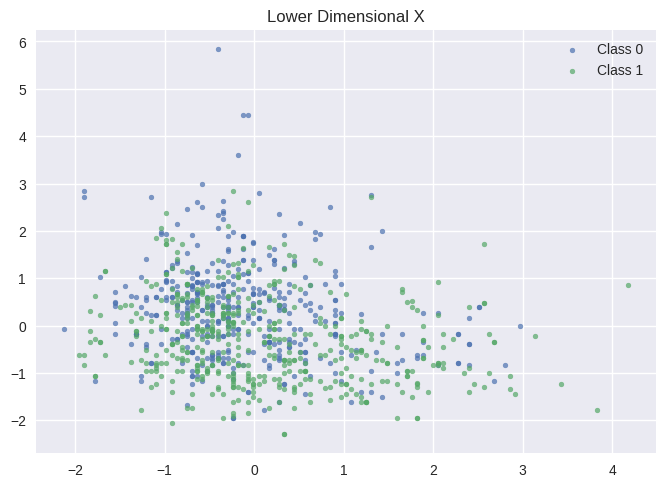

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_train_c)

for class_label in np.unique(y_train_c):
    mask = (np.argmax(y_train_c, -1) == class_label)
    plt.scatter(X_train_c[mask, 0], X_train_c[mask, 1], label=f'Class {int(class_label)}', alpha=0.7, marker='.')
    plt.title('Lower Dimensional X')
    plt.legend()
    
plt.show()

After we plot the lower dimensional data, we can observe that there are a lot of overlaps between the instances of two classes. This might be the reason for slightly poor performance and overfitting of the models that we have trained till now.